## Imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Preprocessing

In [2]:
%%time
# Open data files
path = "./data/"

train = pd.read_csv(path+'train.csv', encoding='iso-8859-1')[::]
test = pd.read_csv(path+'test.csv')
test_ticket_id = np.array(test['ticket_id'])

train = train.set_index('ticket_id')
test = test.set_index('ticket_id')

# Drop the violators who were found not responsible
train.dropna(subset=['compliance'], inplace=True)

# Drop some uninformative features
for column_name in ['inspector_name', 'violator_name',
                    'violation_zip_code', 'violation_street_number', 'violation_street_name',
                    'mailing_address_str_number', 'mailing_address_str_name', 'city',
                    'state', 'zip_code', 'non_us_str_code', 'country',
                    'violation_description',
                    'admin_fee', 'state_fee', 'late_fee']:
    test.drop(column_name, axis=1, inplace=True)



# Convert datetime columns into years/months/days
for column_name in ['ticket_issued_date', 'hearing_date']:
    print('Converting datetime to years/months/days...', column_name)
    
    # test
    day_time = pd.to_datetime(test[column_name])
    test.drop(column_name, axis=1, inplace=True)
    test[column_name+'_month'] = np.array(day_time.dt.month)
    test[column_name+'_year'] = np.array(day_time.dt.year)
    test[column_name+'_day'] = np.array(day_time.dt.day)
    test[column_name+'_dayofweek'] = np.array(day_time.dt.dayofweek)
    
    # train
    day_time = pd.to_datetime(train[column_name])
    train.drop(column_name, axis=1, inplace=True)
    train[column_name+'_month'] = np.array(day_time.dt.month)
    train[column_name+'_year'] = np.array(day_time.dt.year)
    train[column_name+'_day'] = np.array(day_time.dt.day)
    train[column_name+'_dayofweek'] = np.array(day_time.dt.dayofweek)

# Convert string columns to categorical
cols = test.select_dtypes(exclude=['float', 'int']).columns
len_train = len(train)
temp_concat = pd.concat((train[cols], test[cols]), axis=0)

# Some filtering on violation_code to make it more manageable
temp_concat['violation_code'] = temp_concat['violation_code'].apply(lambda x: x.split(' ')[0])
temp_concat['violation_code'] = temp_concat['violation_code'].apply(lambda x: x.split('(')[0])
temp_concat['violation_code'][temp_concat['violation_code'].apply(lambda x: x.find('-')<=0)] = np.nan

# Make all codes with < 10 occurrences null
counts = temp_concat['violation_code'].value_counts()
temp_concat['violation_code'][temp_concat['violation_code'].isin(counts[counts < 10].index)] = np.nan

for column_name in cols:
    print('Converting to categorical...', column_name, '# variables:', len(temp_concat[column_name].unique()))
    dummies = pd.get_dummies(temp_concat[column_name])
    temp_concat[dummies.columns] = dummies
    temp_concat.drop(column_name, axis=1, inplace=True)
    train.drop(column_name, axis=1, inplace=True)
    test.drop(column_name, axis=1, inplace=True)

train[temp_concat.columns] = temp_concat.loc[train.index]
test[temp_concat.columns] = temp_concat.loc[test.index]

features = list( test.columns )
target = ['compliance']

print("Number of features:", len(features))

# Train Set
X = train[features]
y = np.array(train[target]).ravel()

# Normalize
mn = X.mean()
std = X.std()
X = (X - mn)/std

X = X.replace([np.inf, -np.inf], np.nan)
X[pd.isnull(X)] = 0

# Submissions Set
Xtest = (test[features] - mn) / std
Xtest = Xtest.replace([np.inf, -np.inf], np.nan)
Xtest[pd.isnull(Xtest)] = 0

<string>:2: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.


Converting datetime to years/months/days... ticket_issued_date
Converting datetime to years/months/days... hearing_date
Converting to categorical... agency_name # variables: 5
Converting to categorical... violation_code # variables: 72
Converting to categorical... disposition # variables: 8
Converting to categorical... grafitti_status # variables: 2
Number of features: 97
CPU times: user 6.13 s, sys: 2.04 s, total: 8.17 s
Wall time: 7.96 s


## Evaluation

### Define Models

In [3]:
# Imports
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

# Add classifiers
classifiers = {
#     "ASGD": SGDClassifier(average=True),
    "SAG": LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / train[features].shape[0]),
#     "RF_C": RandomForestClassifier(max_depth=25),
    "GradBoost": GradientBoostingClassifier(learning_rate=0.05,
                                            max_features='auto',
                                            max_depth=2,
                                            min_samples_leaf=3,
                                            min_samples_split=4),
#     "VanillaGrad": GradientBoostingClassifier(),
#     'MLP': MLPClassifier()
    "RF_R": RandomForestRegressor(n_estimators=25)
}

# Create Train/Test split for evaluation.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/thealex/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Evaluate with K-Fold Cross Validation

In [4]:
%%time

scores = dict()
# Select the model
for classifier_type in classifiers.keys():
    # Train classifier
    clf = classifiers[classifier_type]
    # Score classifier
    # If using cross_val_score, there is no need for train test split.
    model_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1)
    # Record score
    scores[classifier_type] = model_score

scores = pd.DataFrame(data=scores)
display(scores)

,GradBoost,RF_R,SAG
0,0.922726,-0.088523,0.906558
1,0.940144,0.270197,0.936454
2,0.943207,0.196713,0.938798
3,0.928131,0.122401,0.927881
4,0.928600,0.096223,0.903862


CPU times: user 3.63 s, sys: 475 ms, total: 4.1 s
Wall time: 1min 36s


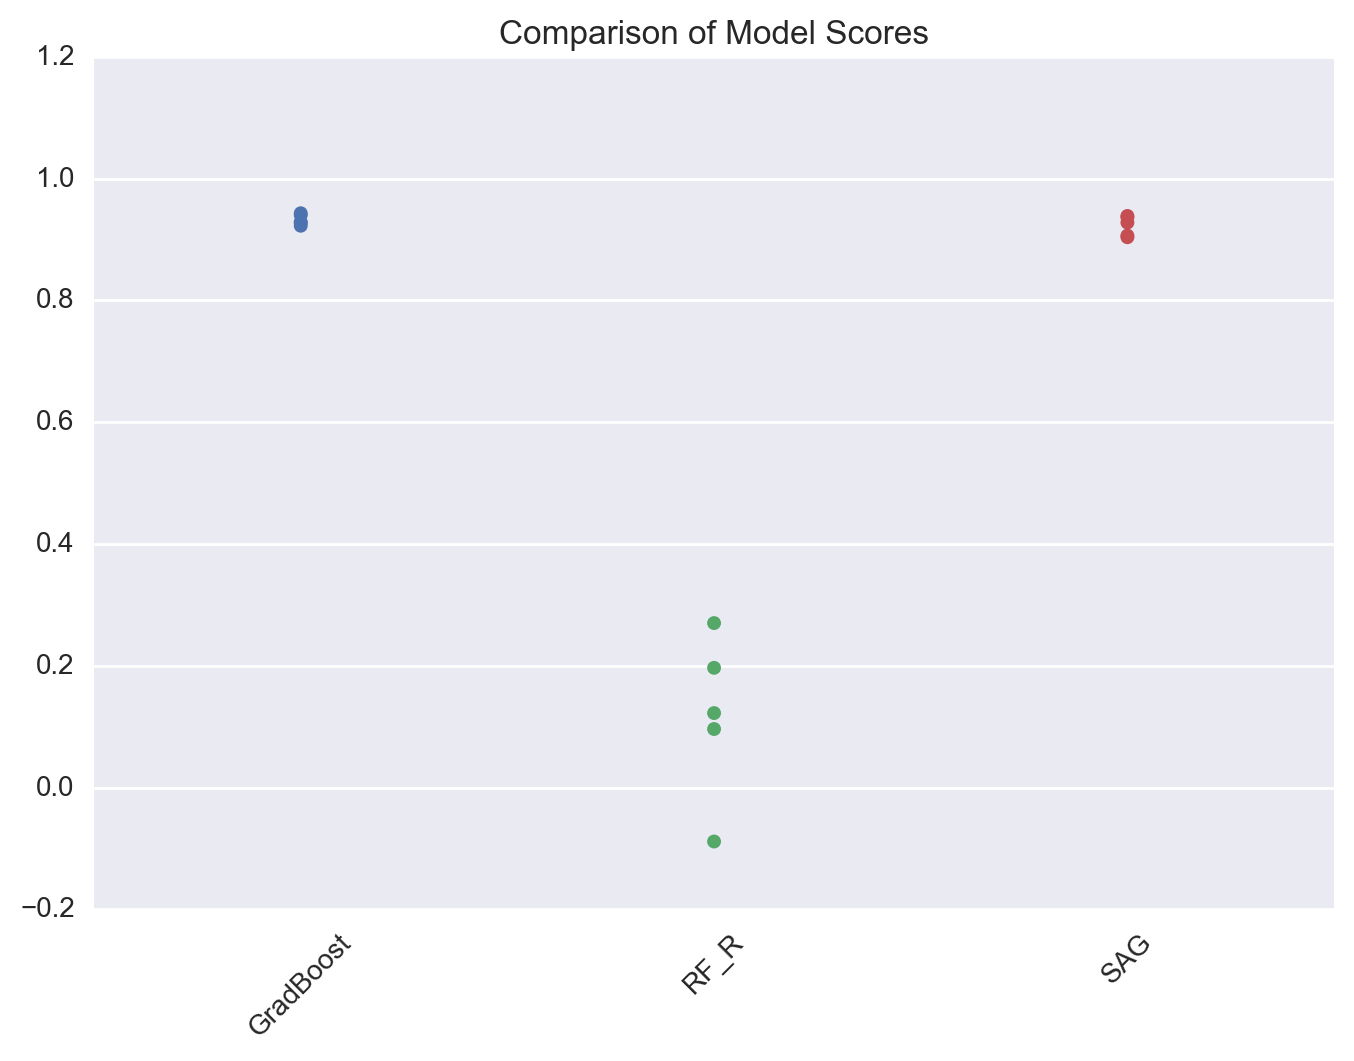

In [5]:
sns.stripplot(data=scores)
plt.xticks(rotation=45)
plt.title('Comparison of Model Scores')

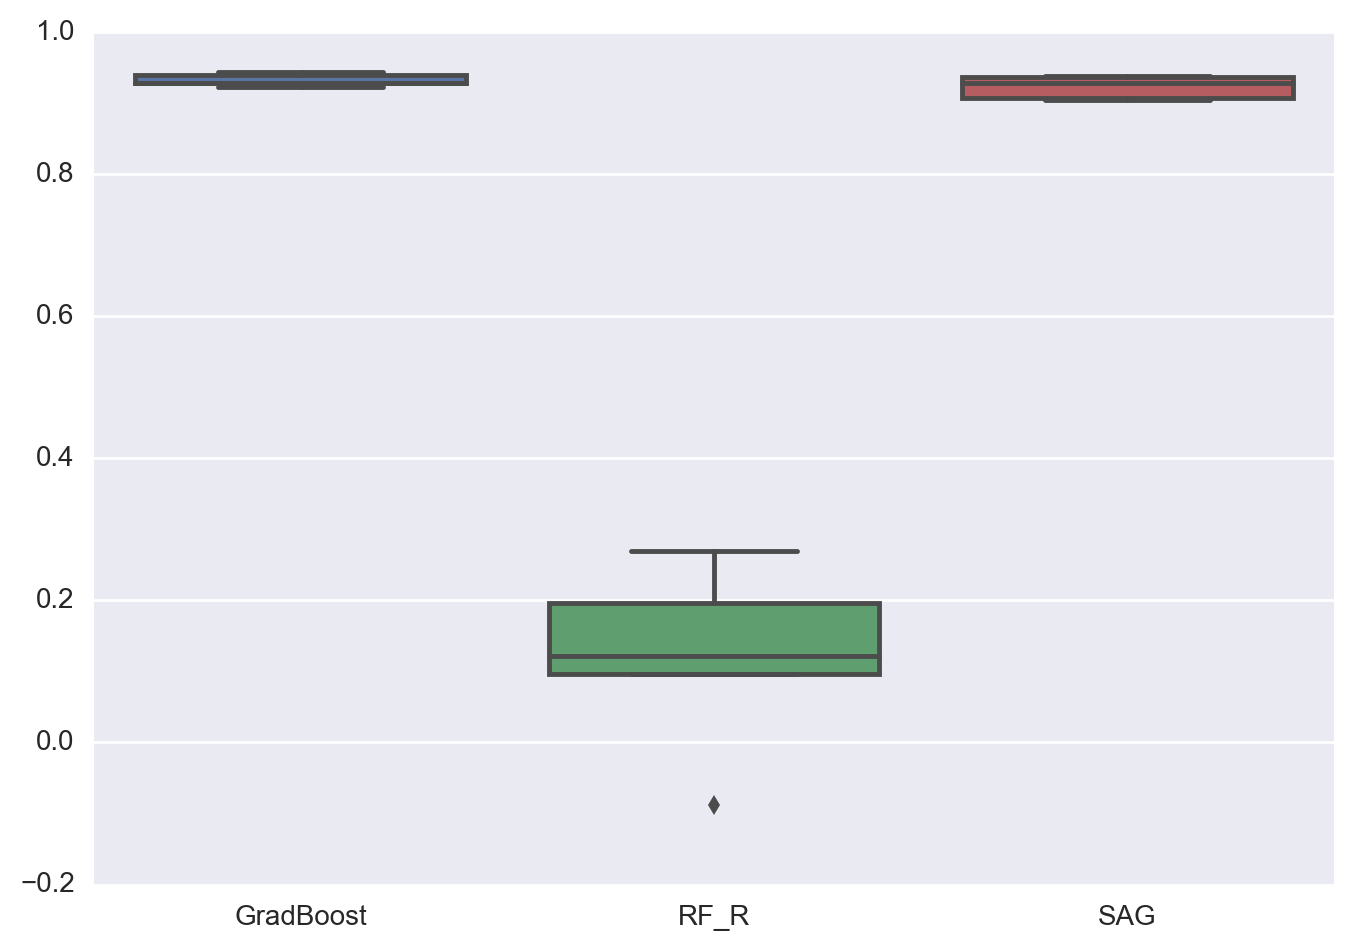

In [6]:
sns.boxplot(data=scores)

## Submission

In [8]:
def make_submission(model_name, clf):
    # Train classifier
    clf.fit(X, y)

    # Predict
    y_pred = np.array(clf.predict(Xtest))
    # If output is scalar, this converts to [0..1]
    y_pred = y_pred - y_pred.min()
    y_pred = y_pred / y_pred.max()

    # Save to CSV
    df = {"ticket_id":test_ticket_id, "compliance":y_pred}
    df = pd.DataFrame(df, columns=["ticket_id", "compliance"])
    df.to_csv("./data/submission_%s.csv" % model_name, index=False)

def make_all_submissions(classifiers):
    """classifiers: A dictionary of classifier name keys and sklearn classifier value pairs"""
    for model_name, clf in classifiers.items():
        make_submission(model_name, clf)

# Make all submissions
# make_all_submissions(classifiers)

# Make individual submission
target_clf = "RF_R"
make_submission(target_clf, classifiers[target_clf])